In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

In [37]:
inWidth = 368
inHeight = 368
thr = 0.3

In [61]:
BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
              ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"]]

In [5]:
img = cv.imread("pose1.jpg")

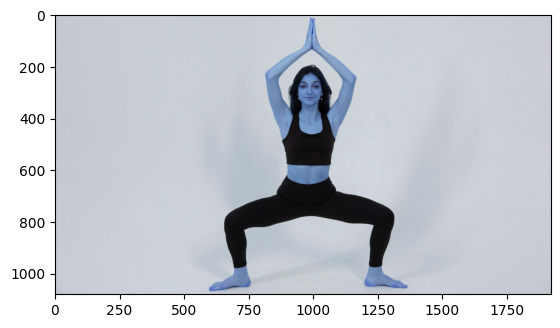

In [6]:
plt.imshow(img)

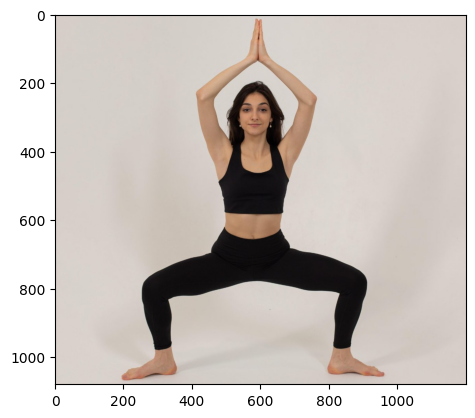

In [7]:
cropped_image = img[0:1200, 400:1600]
plt.imshow(cv.cvtColor(cropped_image, cv.COLOR_BGR2RGB))

In [59]:
def pose_estimation(frame, width = inWidth, height = inHeight):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (width, height), (127.5, 127.5, 127.5), swapRB=True, crop=True))
    out = net.forward()
    out = out[:, :14, :, :]

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        #Slice heatmap of corresponding body's part
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) /out.shape[2]
        #Add a point if it's confidence is higher than threshold
        points.append((int(x), int(y)) if conf > thr else None)
    
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert partFrom in BODY_PARTS, f"{partFrom} is not valid"
        assert partTo in BODY_PARTS, f"{partTo} is not valid"

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 2)
            cv.ellipse(frame, points[idFrom], (2, 2), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (2, 2), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0))
    return frame


# Perform on an image

In [62]:
img = cv.imread("pose1.jpg")
cropped_image = img[0:1200, 400:1600]
estimated_image = pose_estimation(cropped_image)

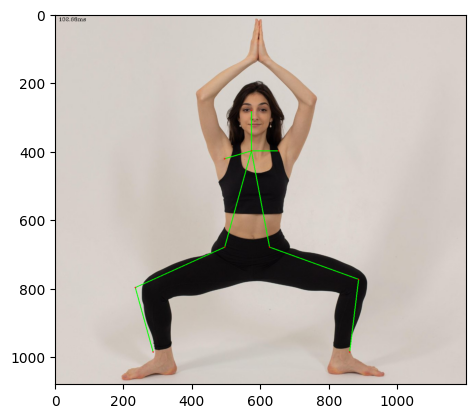

In [63]:
plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))

# Perform on a video

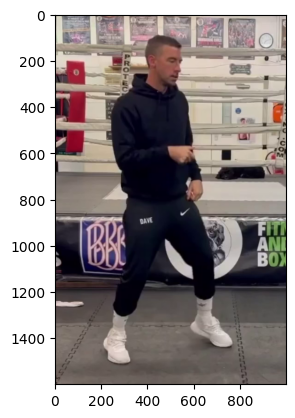

In [54]:
cap = cv.VideoCapture("pose2.mp4")

ret, frame = cap.read()

if ret:
    plt.imshow(cv.cvtColor(frame[0:1600, 0:1000], cv.COLOR_RGB2BGR))
    plt.show()

cap.release()

In [55]:
def resize_and_pad(image, target_size):
    h, w = image.shape[:2]
    aspect_ratio = w / h

    if aspect_ratio > 1: #Frame is wider than being taller
        new_w = target_size
        new_h = int(new_w / aspect_ratio)
    else:
        new_h = target_size #Frame is taller than being wider
        new_w = int(new_h * aspect_ratio)

    resized_image = cv.resize(image, (new_w, new_h))
    padded_image = np.zeros((target_size, target_size, 3), dtype=np.uint8)
    x_offset = (target_size - new_w) // 2
    y_offset = (target_size - new_h) // 2
    padded_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_image

    return padded_image


In [56]:
def display_video(video_path, fps=32):
    cap = cv.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError("Cannot open video")
    
    while cv.waitKey(int(1000/fps)) < 0:
        ret, frame = cap.read()
        if not ret:
            cv.waitKey()
            break

        cv.imshow("Pose estimation result", frame)
    cap.release()
    cv.destroyAllWindows()

In [77]:
cap = cv.VideoCapture("pose2.mp4")

cap.set(cv.CAP_PROP_FPS, 32)
cap.set(cv.CAP_PROP_FRAME_WIDTH, 1600)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 1600)

if not cap.isOpened():
    cap = cv.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open video")

fourcc = cv.VideoWriter_fourcc(*'XVID')
output_video = cv.VideoWriter('output.avi', fourcc, 32.0, (600, 600))

while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
    processed_frame = resize_and_pad(frame, 600)
    estimated_frame = pose_estimation(processed_frame, width=384, height=384)
    output_video.write(estimated_frame)
    cv.imshow("Pose estimation test", processed_frame)
output_video.release()
cap.release()
cv.destroyAllWindows()

In [78]:
display_video("output.avi")

In [66]:
cap = cv.VideoCapture("pose3.mp4")
cap.set(cv.CAP_PROP_FPS, 32)
cap.set(cv.CAP_PROP_FRAME_WIDTH, 1600)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 1600)

if not cap.isOpened():
    raise IOError("Cannot open video")

fourcc = cv.VideoWriter_fourcc(*'XVID')
output_video = cv.VideoWriter('output2.avi', fourcc, 32, (500, 500))

while cv.waitKey(1) < 0:
    hasFrame, frame = cap.read()
    if not hasFrame:
        cv.waitKey()
        break
    processed_frame = resize_and_pad(frame, 500)
    estimated_frame = pose_estimation(processed_frame, width=400, height=400)
    output_video.write(estimated_frame)
    cv.imshow("Pose estimation test 2", estimated_frame)
output_video.release()
cap.release()
cv.destroyAllWindows()

In [69]:
display_video("output2.avi", fps=16)